In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Fri Aug 25 19:52:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [4]:
import os
import zipfile
import requests
import glob as glob
import matplotlib.pyplot as plt
import random
import cv2

## Visualize Ground Truth Images

In [52]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [53]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [54]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    #all_images.extend(glob.glob(image_paths+'/*.JPG'))
    all_labels = glob.glob(label_paths)

    all_images.sort()
    all_labels.sort()

    num_images = len(all_images)
    num_labels = len(all_labels)

    print(num_images,num_labels)
    print(len(image_paths))

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_path=all_images[j]
        image = cv2.imread(image_path)
        txt_file_path = image_path[:-4] + ".txt"
        #txt_file_path = os.path.join(image_path, txt_file_name)
        with open(txt_file_path, 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                print(label_line)
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

3129 3129
56
0 0.33951127529144287 0.7430810928344727 0.4942956268787384 0.4876973032951355
0 0.49814367294311523 0.47736993432044983 0.1259187012910843 0.1581529974937439
0 0.5157132744789124 0.719405472278595 0.9660842418670654 0.5565006732940674


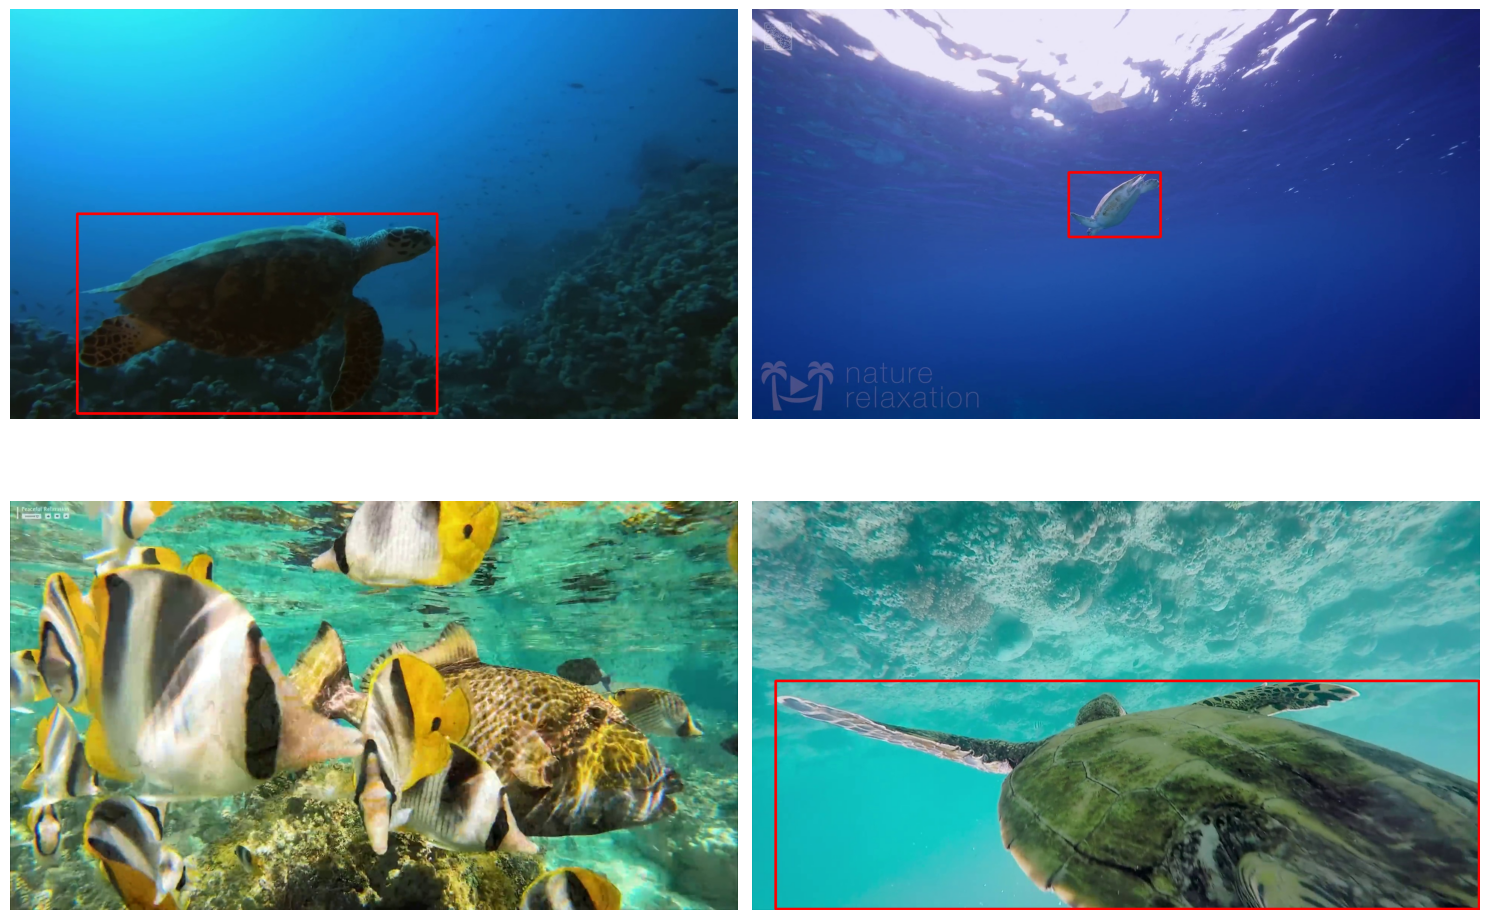

In [55]:
# Visualize a few training images.
plot(
    image_paths='/content/drive/MyDrive/Work/turtle/current_dataset/train',
    label_paths='/content/drive/MyDrive/Work/turtle/current_dataset/train/*.txt',
    num_samples=4,
)

## Setup Fastest

In [5]:
# Clone fastest repository.
if not os.path.exists('Yolo-FastestV2'):
    !git clone https://github.com/dog-qiuqiu/Yolo-FastestV2.git

Cloning into 'Yolo-FastestV2'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 224 (delta 83), reused 177 (delta 60), pack-reused 5
Receiving objects: 100% (224/224), 11.95 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [6]:
%cd /content/Yolo-FastestV2

/content/Yolo-FastestV2


In [7]:
# Check CUDA version.
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


## Prepare Text Files

In [46]:
%%writefile prepare_fastest_image_txt_paths.py
import os

DATA_ROOT_TRAIN = os.path.join(
    '/content/drive/MyDrive/Work/turtle/current_dataset', 'train'
)
DATA_ROOT_VALID = os.path.join(
    '/content/drive/MyDrive/Work/turtle/current_dataset', 'val'
)

DATA_ROOT_TEST = os.path.join(
    '/content/drive/MyDrive/Work/turtle/current_dataset', 'test'
)

train_image_files_names = os.listdir(os.path.join(DATA_ROOT_TRAIN))
with open('train.txt', 'w') as f:
    for file_name in train_image_files_names:
        if not '.txt' in file_name:
            write_name = os.path.join(DATA_ROOT_TRAIN, file_name)
            f.writelines(write_name+'\n')

valid_data_files__names = os.listdir(os.path.join(DATA_ROOT_VALID))
with open('valid.txt', 'w') as f:
    for file_name in valid_data_files__names:
        if not '.txt' in file_name:
            write_name = os.path.join(DATA_ROOT_VALID, file_name)
            f.writelines(write_name+'\n')

test_data_files__names = os.listdir(os.path.join(DATA_ROOT_TEST))
with open('test.txt', 'w') as f:
    for file_name in test_data_files__names:
        if not '.txt' in file_name:
            write_name = os.path.join(DATA_ROOT_TEST, file_name)
            f.writelines(write_name+'\n')

Overwriting prepare_fastest_image_txt_paths.py


In [47]:
!python prepare_fastest_image_txt_paths.py

## Data Preparation

In [10]:
%%writefile data/turtle.names
turtle

Writing data/turtle.names


In [48]:
%%writefile data/turtle.data
classes = 1
train  = train.txt
valid  = valid.txt
names = data/turtle.names
backup = backup_yolov4_tiny

Overwriting data/turtle.data


In [14]:
%%writefile data/turtle_test.data
classes = 1
train  = train.txt
valid  = test.txt
names = data/turtle.names
backup = backup_test/

Writing data/turtle_test.data


In [49]:
#Create Anchor Bias
!python genanchors.py --traintxt ./train.txt

/content/drive/MyDrive/Work/turtle/current_dataset/train/2836.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2680.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2721.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2904.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2820.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2872.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2615.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2899.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2710.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2580.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2598.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2582.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2666.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2796.txt
/content/drive/MyDrive/Work/turtle/current_dataset/train/2860.txt
/content/d

In [50]:
%%writefile data/turtle.data
 [name]
model_name=turtle

 [train-configure]
epochs=300
steps=150,250
batch_size=64
subdivisions=1
learning_rate=0.001

 [model-configure]
pre_weights=modelzoo/coco2017-0.241078ap-model.pth
classes=80
width=352
height=352
anchor_num=3
anchors=12.64,19.39, 37.88,51.48, 55.71,138.31, 126.91,78.23, 131.57,214.55, 279.92,258.87

 [data-configure]
train=/content/Yolo-FastestV2/train.txt
val=/content/Yolo-FastestV2/valid.txt
names=./data/turtle.names

Overwriting data/turtle.data


## Train Fastest

In [51]:
!python train.py --data data/turtle.data

data/turtle.data配置文件里有无效配置项:['[name]']
data/turtle.data配置文件里有无效配置项:['[train-configure]']
data/turtle.data配置文件里有无效配置项:['[model-configure]']
data/turtle.data配置文件里有无效配置项:['[data-configure]']
训练配置:
{'model_name': 'turtle', 'epochs': 300, 'steps': [150.0, 250.0], 'batch_size': 64, 'subdivisions': 1, 'learning_rate': 0.001, 'pre_weights': 'modelzoo/coco2017-0.241078ap-model.pth', 'classes': 80, 'width': 352, 'height': 352, 'anchor_num': 3, 'anchors': [12.64, 19.39, 37.88, 51.48, 55.71, 138.31, 126.91, 78.23, 131.57, 214.55, 279.92, 258.87], 'val': '/content/Yolo-FastestV2/valid.txt', 'train': '/content/Yolo-FastestV2/train.txt', 'names': './data/turtle.names'}
load param...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 176, 176]             648
       BatchNorm2d-2         [-1, 24, 176, 176]              48
              ReLU-3         [-1, 24, 176, 176]               0
  

**Testing/Checking our results below**

In [56]:
!python3 evaluation.py --data data/turtle.data --weights [path to generated weights]

usage: evaluation.py
       [-h]
       [--data DATA]
       [--weights WEIGHTS]
evaluation.py: error: unrecognized arguments: to generated weights]
